# Neural Network Mortgage Prepayment Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import time
import imp
import os
import os, os.path
import datetime as dt
import dateutil.parser as dp
import dill
import datetime as dt

%matplotlib inline

## Load data from csv files in the ./data directory

In [2]:
if True:
    # load data from csv files
    df = pd.DataFrame()
    for root, dirs, files in os.walk("./data"):
        for name in files:
            file_name = os.path.join(root, name)
            if 'pools_ge250_loans' in file_name:
                if len(df) > 0:
                    df = pd.concat([df,pd.read_csv(file_name)])
                else:
                    df = pd.read_csv(file_name)        

    model_name = 'nn-ppm-from-csv.h5' # for saving a model later

else:
    dill.load_session('notebook_env_all_3_dfs.db')

    print('Loaded data as is:')
    print('attr_df.shape   = ', attr_df.shape)
    print('geo_df.shape    = ', geo_df.shape)
    print('seller_df.shape = ', seller_df.shape)

    nloans = 250
    attr_df = attr_df[attr_df['cnloans']>=nloans]

    print('Data size after filtering for >= 250 loans:')
    print(f'attr_df.shape = {attr_df.shape}')

    geo_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(attr_df,geo_df,on=['cusip','asofdate'],how='left')

    seller_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(df,seller_df,on=['cusip','asofdate'],how='left')

    df.fillna(0,inplace=True)

    model_name = 'nn-ppm-dill-data.h5' # for saving a model later

df['Seasonality'] = df['asofdate'].apply(lambda x: int(str(x)[-2:]))

print('df.shape = ', df.shape)

df.shape =  (594533, 111)


### Make sure all the fields (except cusip and poolsno) are numerical and there are no NAs

In [3]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594533 entries, 0 to 29999
Data columns (total 111 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   poolno              594533 non-null  object 
 1   asofdate            594533 non-null  int64  
 2   cusip               594533 non-null  object 
 3   spread              594533 non-null  float64
 4   SMM                 594533 non-null  float64
 5   DayCount            594533 non-null  float64
 6   OBal                594533 non-null  float64
 7   CBal                594533 non-null  float64
 8   factor              594533 non-null  float64
 9   Coupon              594533 non-null  float64
 10  Wac                 594533 non-null  float64
 11  Wam                 594533 non-null  float64
 12  Age                 594533 non-null  float64
 13  aols                594533 non-null  float64
 14  waols               594533 non-null  float64
 15  ONLoans             594533 non-nul

In [4]:
df.head()

poolno  asofdate      cusip  spread     SMM  DayCount         OBal  \
0  932473    201002  31412Q6J3    -2.7  0.1184      19.0  503049960.0   
1  932473    201003  31412Q6J3    -5.7  0.2017      23.0  503049960.0   
2  932473    201004  31412Q6J3    -2.6  0.0811      22.0  503049960.0   
3  932473    201005  31412Q6J3    -7.9  0.3476      20.0  503049960.0   
4  932473    201006  31412Q6J3    -4.0  0.6786      22.0  503049960.0   

           CBal     factor  Coupon  ...  SellerPct_NATIONST  SellerPct_NRESM  \
0  5.012071e+08  99.633659     4.5  ...                 0.0              0.0   
1  4.995732e+08  99.308870     4.5  ...                 0.0              0.0   
2  4.985434e+08  99.104151     4.5  ...                 0.0              0.0   
3  4.961853e+08  98.635394     4.5  ...                 0.0              0.0   
4  4.921947e+08  97.842115     4.5  ...                 0.0              0.0   

   SellerPct_PNYMAC  SellerPct_PILOSI  SellerPct_QUICK  SellerPct_REG  \
0               0.0               0.0              0.0            0.0   
1               0.0               0.0              0.0            0.0   
2               0.0               0.0              0.0            0.0   
3               0.0               0.0              0.0            0.0   
4               0.0               0.0              0.0            0.0   

   SellerPct_RMSC  SellerPct_UNSHFI  SellerPct_WFHM  Seasonality  
0             0.0               0.0             0.0            2  
1             0.0               0.0             0.0            3  
2             0.0               0.0             0.0            4  
3             0.0               0.0             0.0            5  
4             0.0               0.0             0.0            6  

[5 rows x 111 columns]

## Exploratory data analysis

Here we show some of the typical dependencies between prepayment speeds and some of the pools attributes.

* Prepayment speeds tend to be faster for loans of higher sizes.
* Prepayment speeds tend to be slower for investor loans, because investor loans have much higher closing costs and thus, more expensive to refinance. 
* It does matter which financial institution has originated a loan. The example we give here is comparing loans originated by Quicken to the rest of the loan population. Quicken loans tend to be much faster and it's imoprtant for a model to capture that. 

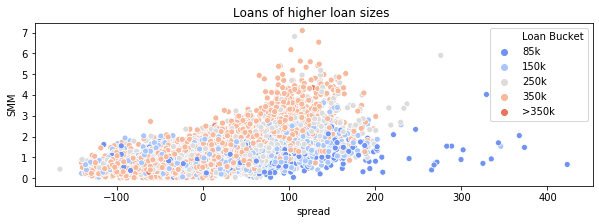

In [5]:
temp = df[(df['Age']>=24) & (df['cnloans']>500)].sample(10000)

temp['Loan Bucket'] = temp['waols'].apply(lambda x: '85k' if x<=85e3 
                                                          else '150k' if x<=150e3 
                                                          else '250k' if x<=250e3 
                                                          else '350k' if x<=350e3
                                                          else '>350k')

plt.figure(figsize=(10,3))
plt.title('Loans of higher loan sizes ')
sns.scatterplot(x='spread',y='SMM',data=temp,hue='Loan Bucket',
                hue_order=['85k','150k','250k','350k','>350k'],
                palette='coolwarm')

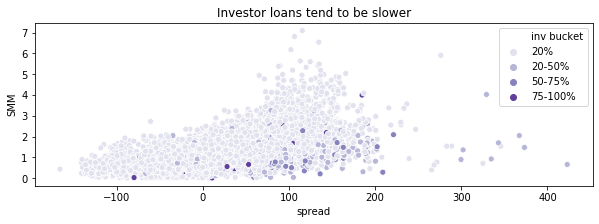

In [6]:
temp['inv bucket'] = temp['OccPct_investor'].apply(lambda x: '20%' if x<20
                                                  else '20-50%' if x<50
                                                  else '50-75%' if x<75
                                                  else '75-100%')
plt.figure(figsize=(10,3))
plt.title('Investor loans tend to be slower')
sns.scatterplot(x='spread',y='SMM',data=temp,hue='inv bucket',palette='Purples',hue_order=['20%','20-50%','50-75%','75-100%'])

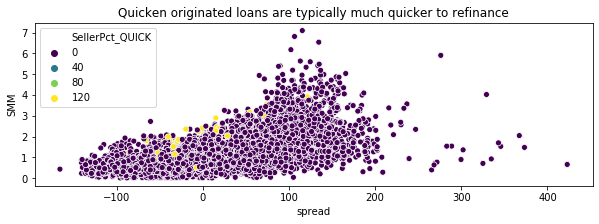

In [7]:
plt.figure(figsize=(10,3))
plt.title('Quicken originated loans are typically much quicker to refinance')
sns.scatterplot(x='spread',y='SMM',data=temp,hue='SellerPct_QUICK',palette='viridis')

## Model features selection and defining train/test split

* In this section we select which features (columns) are to be used in the model and define a test-train split. 
* For the train set we use the mortgage prepayment data observed in the period of 2010-2016. 
* For the test set we use the period from 2017 - Feb 2020. 

In [8]:
model_columns = ['asofdate',
                 'SMM',
                 'spread',
                 'DayCount','factor',
                 'Wac','Wam','Age','aols','waols','CSato',
                 'oltv','cltv','ocltv','ccltv',
                 'fico',
                 '%CashWindow','%Majors',
                 'PurpPct_purchase','PurpPct_refi',
                 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
                 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
                 'Seasonality',
                
                 # features showing geographical composition of a pool
                 'StatePct_AK','StatePct_AL','StatePct_AR','StatePct_AZ','StatePct_CA','StatePct_CO','StatePct_CT',
                 'StatePct_DC','StatePct_DE','StatePct_FL','StatePct_GA','StatePct_GU','StatePct_HI','StatePct_IA',
                 'StatePct_ID','StatePct_IL','StatePct_IN','StatePct_KS','StatePct_KY','StatePct_LA','StatePct_MA',
                 'StatePct_MD','StatePct_ME','StatePct_MI','StatePct_MN','StatePct_MO','StatePct_MS','StatePct_MT',
                 'StatePct_NC','StatePct_ND','StatePct_NE','StatePct_NH','StatePct_NJ','StatePct_NM','StatePct_NV',
                 'StatePct_NY','StatePct_OH','StatePct_OK','StatePct_OR','StatePct_PA','StatePct_PR','StatePct_RI',
                 'StatePct_SC','StatePct_SD','StatePct_TN','StatePct_TX','StatePct_UT','StatePct_VA','StatePct_VI',
                 'StatePct_VT','StatePct_WA','StatePct_WI','StatePct_WV','StatePct_WY',
                 
                 # features showing originator composition of a pool
                 'SellerPct_AMRHT','SellerPct_ALS','SellerPct_CAFULL','SellerPct_CNTL','SellerPct_CITIZ',
                 'SellerPct_53','SellerPct_FIR','SellerPct_FRDOM','SellerPct_GUILD','SellerPct_CHASE',
                 'SellerPct_LLSL','SellerPct_MATRX','SellerPct_NCM','SellerPct_NATIONST','SellerPct_NRESM',
                 'SellerPct_PNYMAC','SellerPct_PILOSI','SellerPct_QUICK','SellerPct_REG','SellerPct_RMSC',
                 'SellerPct_UNSHFI','SellerPct_WFHM']

dfm = df[model_columns]

print(f'dfm.shape = {dfm.shape}')

dfm.head()

dfm.shape = (594533, 103)


asofdate     SMM  spread  DayCount     factor    Wac    Wam  Age      aols  \
0    201002  0.1184    -2.7      19.0  99.633659  4.953  355.0  2.0  257940.0   
1    201003  0.2017    -5.7      23.0  99.308870  4.953  354.0  3.0  257971.0   
2    201004  0.0811    -2.6      22.0  99.104151  4.953  353.0  4.0  257930.0   
3    201005  0.3476    -7.9      20.0  98.635394  4.954  352.0  5.0  257972.0   
4    201006  0.6786    -4.0      22.0  97.842115  4.953  350.0  6.0  257650.0   

      waols  ...  SellerPct_NCM  SellerPct_NATIONST  SellerPct_NRESM  \
0  257940.0  ...            0.0                 0.0              0.0   
1  257971.0  ...            0.0                 0.0              0.0   
2  257930.0  ...            0.0                 0.0              0.0   
3  257972.0  ...            0.0                 0.0              0.0   
4  257650.0  ...            0.0                 0.0              0.0   

   SellerPct_PNYMAC  SellerPct_PILOSI  SellerPct_QUICK  SellerPct_REG  \
0               0.0               0.0              0.0            0.0   
1               0.0               0.0              0.0            0.0   
2               0.0               0.0              0.0            0.0   
3               0.0               0.0              0.0            0.0   
4               0.0               0.0              0.0            0.0   

   SellerPct_RMSC  SellerPct_UNSHFI  SellerPct_WFHM  
0             0.0               0.0             0.0  
1             0.0               0.0             0.0  
2             0.0               0.0             0.0  
3             0.0               0.0             0.0  
4             0.0               0.0             0.0  

[5 rows x 103 columns]

In [9]:
dummies = pd.get_dummies(dfm['Seasonality'],drop_first=True)
dfm = dfm.drop('Seasonality',axis=1)
dfm = pd.concat([dfm,dummies],axis=1)

print(f'dfm.shape = {dfm.shape}')

dfm.shape = (594533, 113)


In [10]:
# define train/test split
# from sklearn.model_selection import train_test_split

# X = dfm.drop(['SMM','asofdate'],axis=1)
# y = dfm['SMM'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

dfm_train = dfm[dfm['asofdate'] <  201701]
dfm_test  = dfm[dfm['asofdate'] >= 201701]

X_train = dfm_train.drop(['SMM','asofdate'],axis=1).values
y_train = dfm_train['SMM'].values

X_test = dfm_test.drop(['SMM','asofdate'],axis=1).values
y_test = dfm_test['SMM'].values

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print('\n')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (328786, 111)
y_train.shape = (328786,)


X_test.shape  = (265747, 111)
y_test.shape  = (265747,)


## Building a benchmark model 1 (Linear regression)

* Here we build a simple linear regression model and examine its predictive ability on our prepayment dataset.

In [136]:
from sklearn.linear_model import LinearRegression

In [137]:
linear_model = LinearRegression()

In [138]:
linear_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [139]:
if 'asofdate' in dfm.columns:
    df['model SMM'] = linear_model.predict(dfm.drop(['SMM','asofdate'],axis=1))
else:
    df['model SMM'] = linear_model.predict(dfm.drop('SMM',axis=1))

In [140]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

In [141]:
def valReport(dframe,graphTitle='',lcoup=2.5,hcoup=5,fsize=(24,24)):

    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    fig = plt.figure(figsize=fsize)
    
    plt.title(graphTitle)

    numOfsubgraphs = int((hcoup-lcoup)*2 + 1)

    for i in range(numOfsubgraphs):
        ax = fig.add_subplot(numOfsubgraphs,1,i+1)
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].plot(ax=ax,grid=True)
            ax.legend()

In [192]:
def rmse_by_coupon(dframe,lcoup=2.5,hcoup=5,col_name='RMSE (CPR)'):
    
    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    RMSE_by_coupon = dict()
    
    for i in range(int((hcoup-lcoup)*2 + 1)):
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            act_vs_pred = ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].dropna()
            RMSE_by_coupon[coupon] = np.sqrt(mean_squared_error(act_vs_pred[('CPR',coupon)],act_vs_pred[('model CPR'),coupon]))
            
    RMSE_by_coupon = pd.DataFrame({col_name:list(RMSE_by_coupon.values())},index=RMSE_by_coupon.keys())
    RMSE_by_coupon.index.name = 'Coupon'
    
    return RMSE_by_coupon    

### Validation of a linear model on a pool by pool basis. 

* The results below show that linear model explaines very little variance on the test set.
* The later can also be easily observed on the scatter plot below comparing predictions on the test set to actuals.

In [143]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = linear_model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = linear_model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

(test set) mean absolute error       = 0.5625
(test set) mean sq root sq error     = 0.7323
(test set) explained variance score  = 0.0161


(train set) mean absolute error      = 0.5518
(train set) mean sq root sq error    = 0.7749
(train set) explained variance score = 0.4392


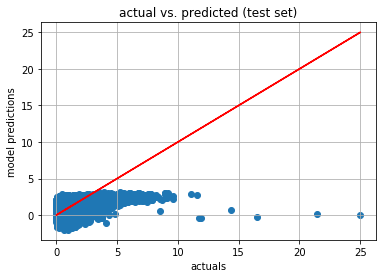

In [144]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

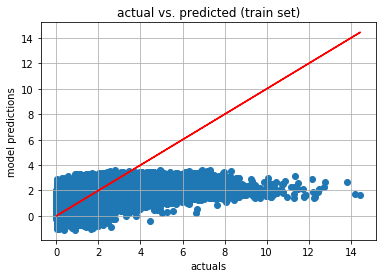

In [145]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

### Validation of a linear model on large populations of pools/loans

* What stands out immediately is that some of the model predictions predict negative prepayments (CPRs), which shouldn't happen as CPRs should always be non-negative. 
* We also see that our out of sample model predictions, especially on 2.5s and 3a, can be off by more than 10 CPR, which is generally considered unacceptable on such large sub-cohorts. 

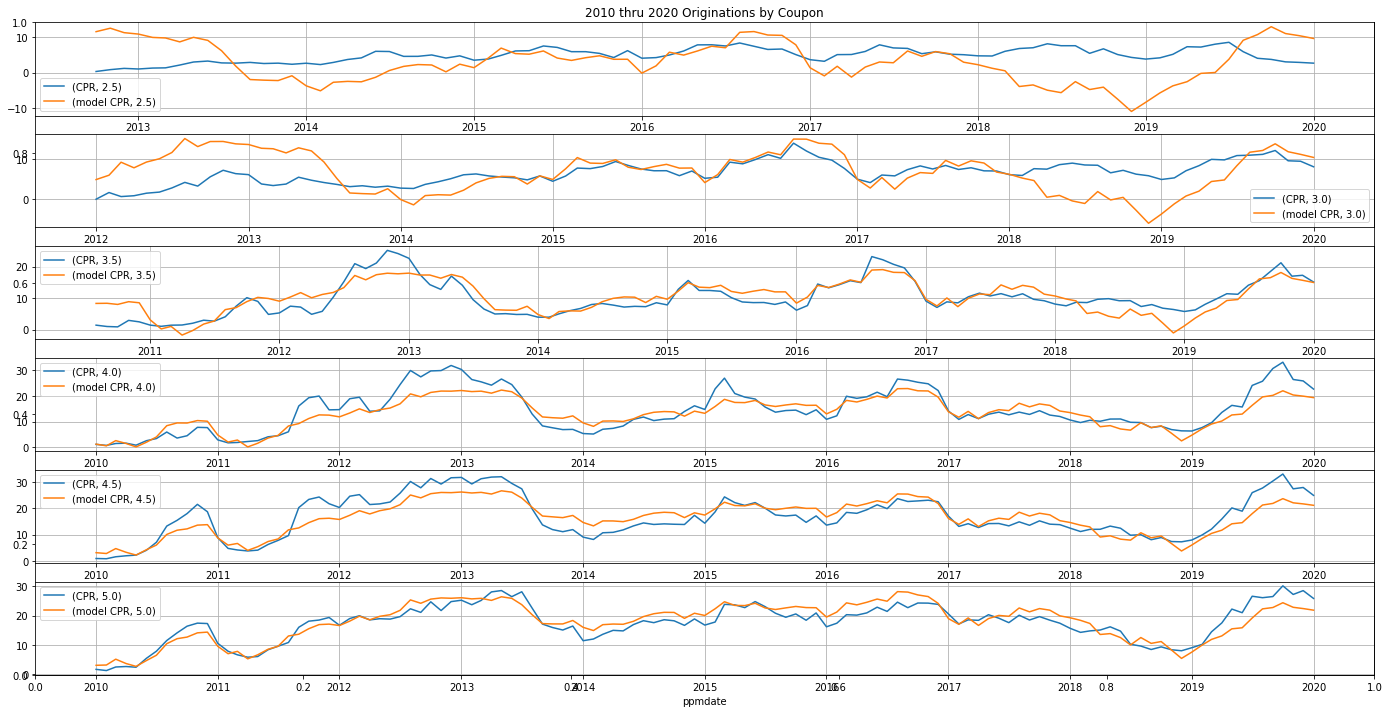

In [146]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

In [200]:
RMSEs_linear_model = rmse_by_coupon(df[df['asofdate'] >= 201701],col_name='LM RMSE (CPR)')
np.round(RMSEs_linear_model,2)

LM RMSE (CPR)
Coupon               
2.5              1.37
3.0              1.02
3.5              1.37
4.0              3.16
4.5              3.14
5.0              3.63

### Conclusions about using a linear model for predicting prepayment speeds

* We conclude that a linear model suffers from some serious drawbacks and is generally cannot be used for predicting residential modetgage prepayments with a level of acceptable accuracy. 

## Building a benchmark model 2 (Random forest)

* We thought it would be interesting to compare our neural network to a random forest as well.
* People in finance prefer decision trees type models to neural networks, when possible, because of the black box nature of neural networks. 

In [172]:
from sklearn.ensemble import RandomForestRegressor

In [173]:
rf_model = RandomForestRegressor(n_estimators=30,verbose=1)

In [174]:
rf_model.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.1min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

In [175]:
if 'asofdate' in dfm.columns:
    df['model SMM'] = rf_model.predict(dfm.drop(['SMM','asofdate'],axis=1))
else:
    df['model SMM'] = rf_model.predict(dfm.drop('SMM',axis=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.6s finished


In [176]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

### Validation of a random forest model on a pool by pool basis.

* The results below show that a random forest model has decent predictive ability on the test set.
* The model's ability to fit to the train set seems to be quite amazing. 
* There are still some large outliers in model predictions, but it is generally considered normal and the real test is how the model performs on large populations of pools/loans, where prepayment speeds are typically more stable and more predictible. 

In [177]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = rf_model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = rf_model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(test set) mean absolute error       = 0.3916
(test set) mean sq root sq error     = 0.5446
(test set) explained variance score  = 0.3923


(train set) mean absolute error      = 0.1435
(train set) mean sq root sq error    = 0.2157
(train set) explained variance score = 0.9565


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.1s finished


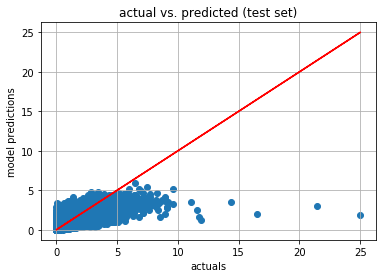

In [178]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

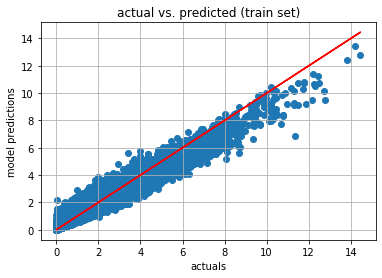

In [179]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

### Validation of a random forest model on large populations of pools/loans

* It appears that the model performance on out of sample (test) set can be quite "jumpy". 
* This especially can be seen on out of sample model performance on 2.5s and 3s (first 2 sub-graphs below). 
* Model performance on 5s in the period of mid to late 2017 is also concerning as historical prepayment speeds were non-increasing and also decreasing over that period, wheres the model has predicted for the prepayment speeds to pick up. 

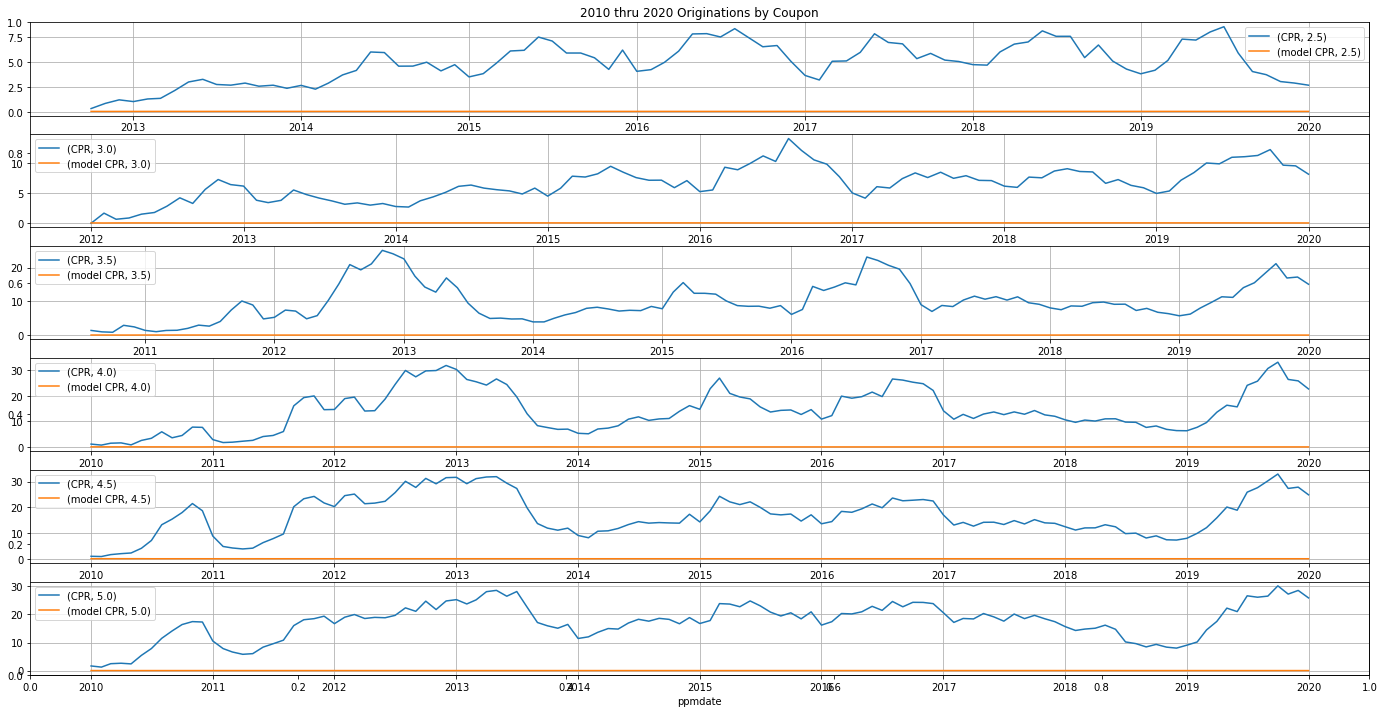

In [180]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

In [201]:
RMSEs_random_forest = rmse_by_coupon(df[df['asofdate']>=201701],col_name='RF RMSE (CPR)')
np.round(RMSEs_random_forest,2)

RF RMSE (CPR)
Coupon               
2.5              1.37
3.0              1.02
3.5              1.37
4.0              3.16
4.5              3.14
5.0              3.63

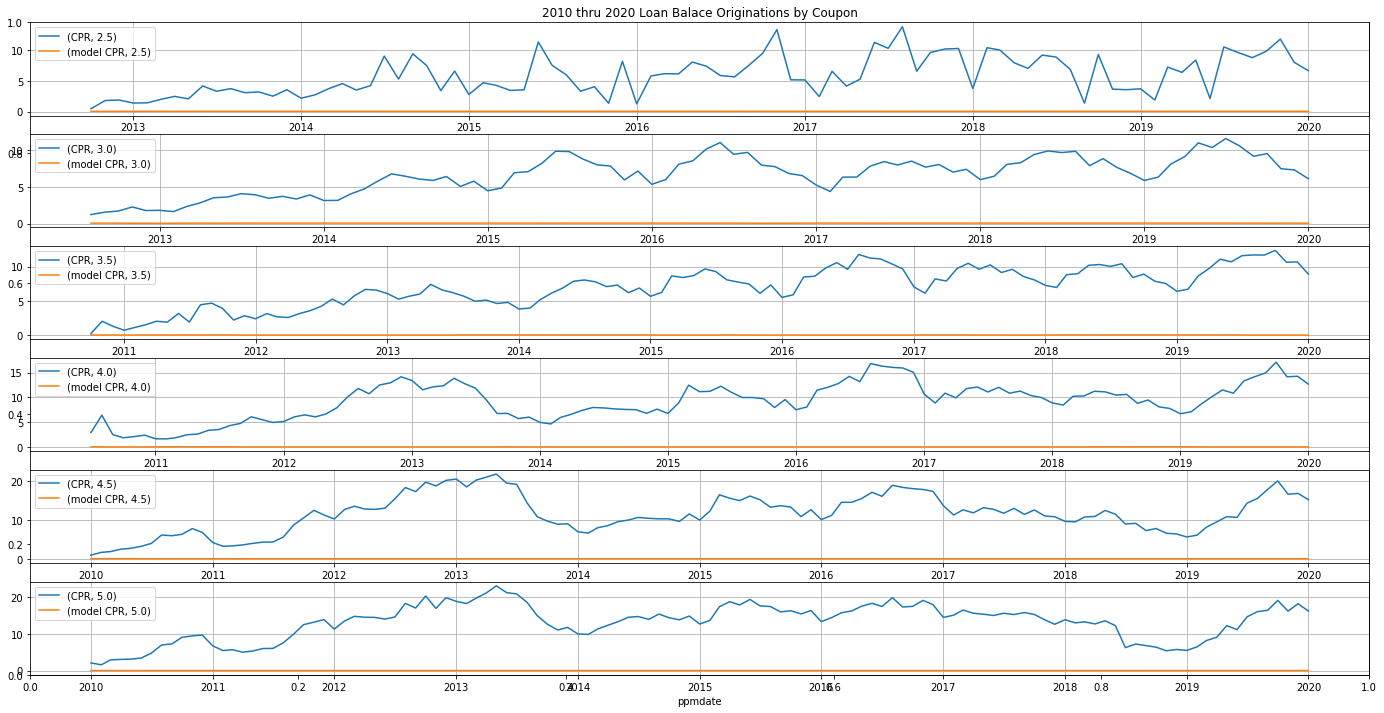

In [182]:
valReport(df[df['waols'] <= 200000],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))

### Conclusions about using a random forest model for predicting prepayment speeds

* We conclude that a random forest model seems to be a promising candidate for a mortgage prepayment model, however, more research is needed into reducing overfitting and making model predictions more stable on large and relevant populations of loans.  

## Building a training of a FF neural-network mortgage prepayment model

In [156]:
# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [157]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

In [33]:
model = Sequential()

#input layer / first hidden layer
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

# hidden layers
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dropout(0.5))

#output layer
model.add(Dense(1, activation='relu')) # no activation means linear activation a(x)=x
#model.add(Dense(1)) # no activation means linear activation a(x)=x

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='rmsprop', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [34]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          batch_size=1024,
          epochs=300)

Train on 328786 samples, validate on 265747 samples
Epoch 1/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.7185 - val_loss: 0.3095
Epoch 2/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4800 - val_loss: 0.2931
Epoch 3/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4446 - val_loss: 0.3085
Epoch 4/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4211 - val_loss: 0.3070
Epoch 5/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.4115 - val_loss: 0.3009
Epoch 6/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.4008 - val_loss: 0.2930
Epoch 7/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3953 - val_loss: 0.2855
Epoch 8/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3923 - val_loss: 0.2871
Epoch 9/300
328786/328786 [==============================] - 7s 21us

328786/328786 [==============================] - 7s 21us/sample - loss: 0.3124 - val_loss: 0.2947
Epoch 148/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3110 - val_loss: 0.2954
Epoch 149/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3113 - val_loss: 0.2892
Epoch 150/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3124 - val_loss: 0.2860
Epoch 151/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3102 - val_loss: 0.2862
Epoch 152/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3112 - val_loss: 0.2902
Epoch 153/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3104 - val_loss: 0.2876
Epoch 154/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3105 - val_loss: 0.2905
Epoch 155/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.3088 - val_loss: 0.2935
Epoch 

328786/328786 [==============================] - 7s 21us/sample - loss: 0.3005 - val_loss: 0.2878
Epoch 294/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.3004 - val_loss: 0.2900
Epoch 295/300
328786/328786 [==============================] - 7s 22us/sample - loss: 0.2987 - val_loss: 0.2893
Epoch 296/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2983 - val_loss: 0.2863
Epoch 297/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2980 - val_loss: 0.2870
Epoch 298/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2989 - val_loss: 0.2895
Epoch 299/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2990 - val_loss: 0.2968
Epoch 300/300
328786/328786 [==============================] - 7s 21us/sample - loss: 0.2999 - val_loss: 0.2884


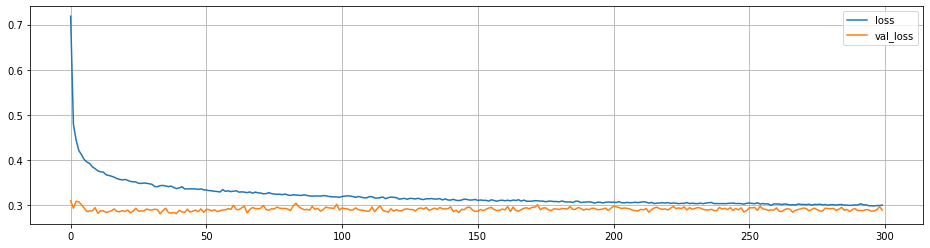

In [35]:
losses = pd.DataFrame(model.history.history)

losses.plot(figsize=(16,4),grid=True)

## Model Evaluation and Validation

* In this section we find that the model performs quite well on large populations of loans, however, on individual pools it can be off by quite a bit, especially, if a pool is small. It is normal for prepayment models to behave that way. Afterall, we are modeling the behaviour of people and people are not entirely defined by their FICO score and other similar attributes. 

### Validation of a neural-network model on a pool by pool basis.

* The results below show that a neural network type prepayment model has a decent prediction ability on a test set with similar averages to a random forest model. 
* There are still some large outliers in model predictions, but it is generally considered normal and the real test is how the model performs on large populations of pools/loans, where prepayment speeds are typically more stable and more predictible. 

In [183]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

(test set) mean absolute error       = 0.3921
(test set) mean sq root sq error     = 0.537
(test set) explained variance score  = 0.4097


(train set) mean absolute error      = 0.3764
(train set) mean sq root sq error    = 0.5195
(train set) explained variance score = 0.7488


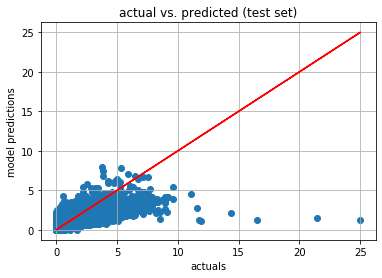

In [184]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

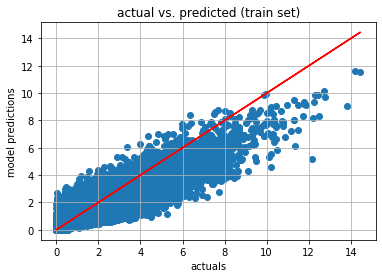

In [185]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

### Validation of a neural network model on large populations of pools/loans

* The model appears to exhibit a stable and an intuitive performance on the in/out of sample sets. 
* The model errors appear to be of acceptable magnitude, especially considering a very large out of sample period (3 years long).
* We find that the model performs particularly well on  
    * Loan balance pools, i.e. pools where loan size does not exceed 200k.
    * Cash window pools, i.e. pools originated by very small originators.
    * Retail originated loans, i.e. not Broker or Correspondent originated pools.

In [186]:
if 'asofdate' in dfm.columns:
    df['model SMM'] = model.predict(scaler.transform(dfm.drop(['SMM','asofdate'],axis=1)))
else:
    df['model SMM'] = model.predict(scaler.transform(dfm.drop('SMM',axis=1)))

In [187]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

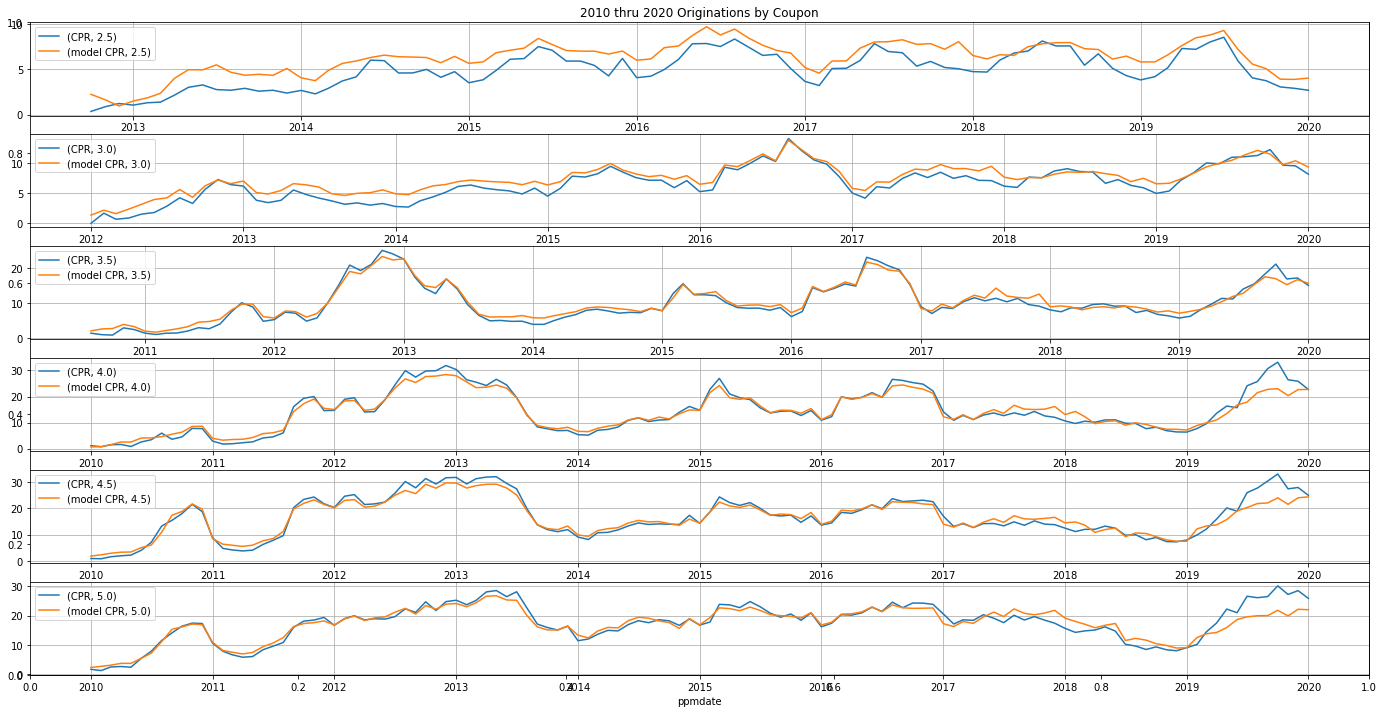

In [188]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,12))

In [202]:
RMSEs_nn = rmse_by_coupon(df[df['asofdate']>=201701],col_name='NN RMSE (CPR)')
np.round(RMSEs_nn,2)

NN RMSE (CPR)
Coupon               
2.5              1.37
3.0              1.02
3.5              1.37
4.0              3.16
4.5              3.14
5.0              3.63

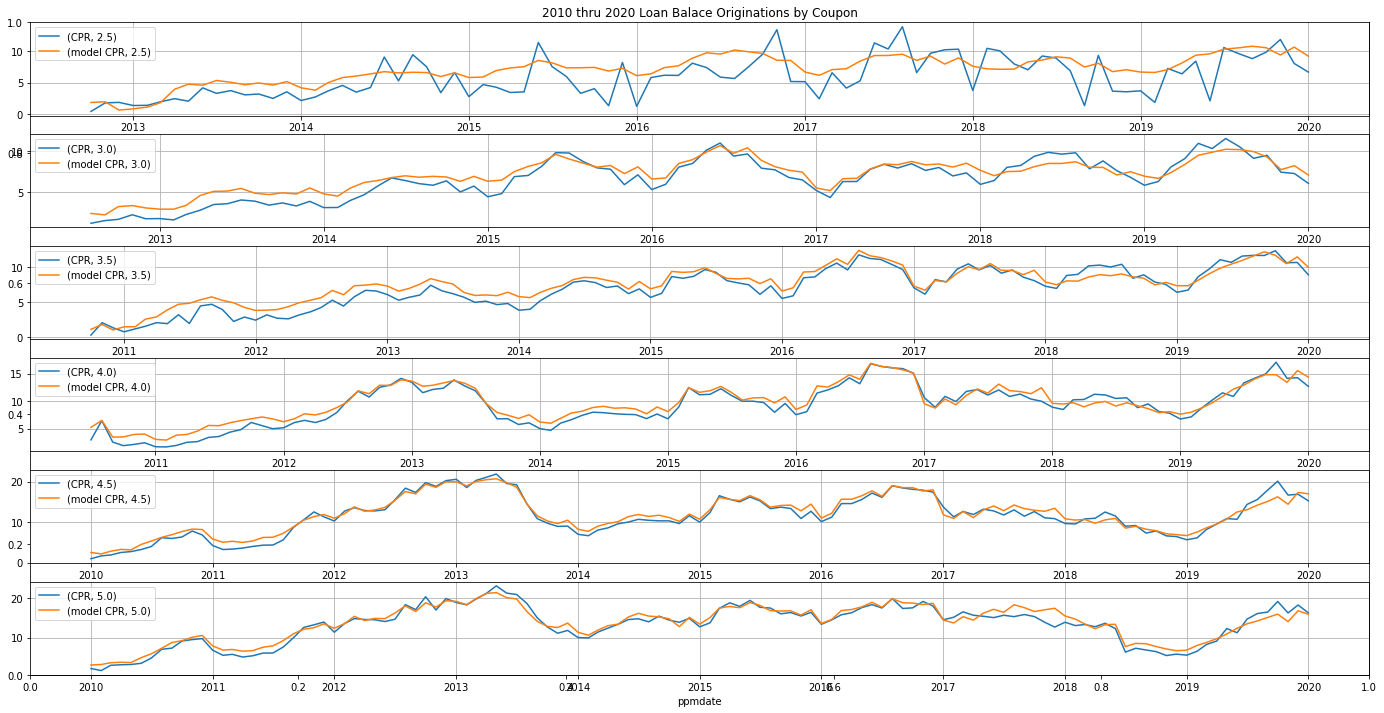

In [42]:
valReport(df[df['waols'] <= 200000],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))

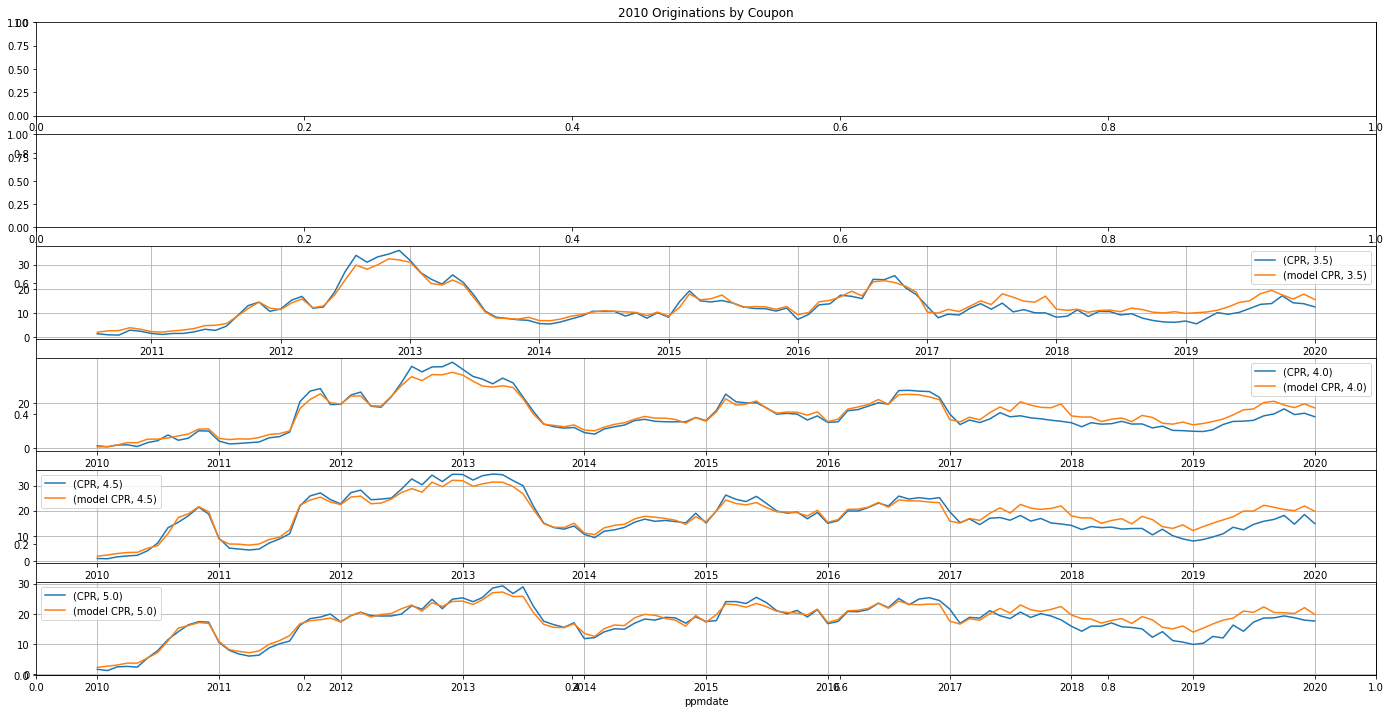

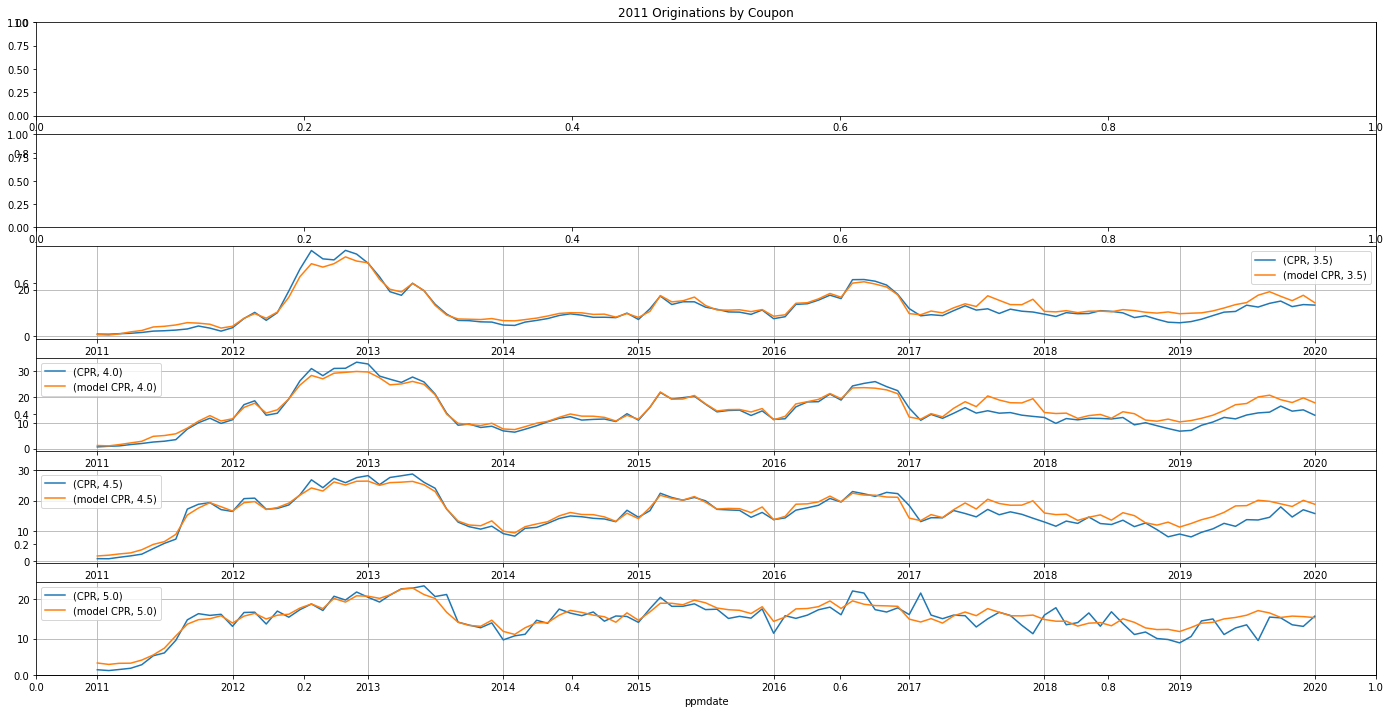

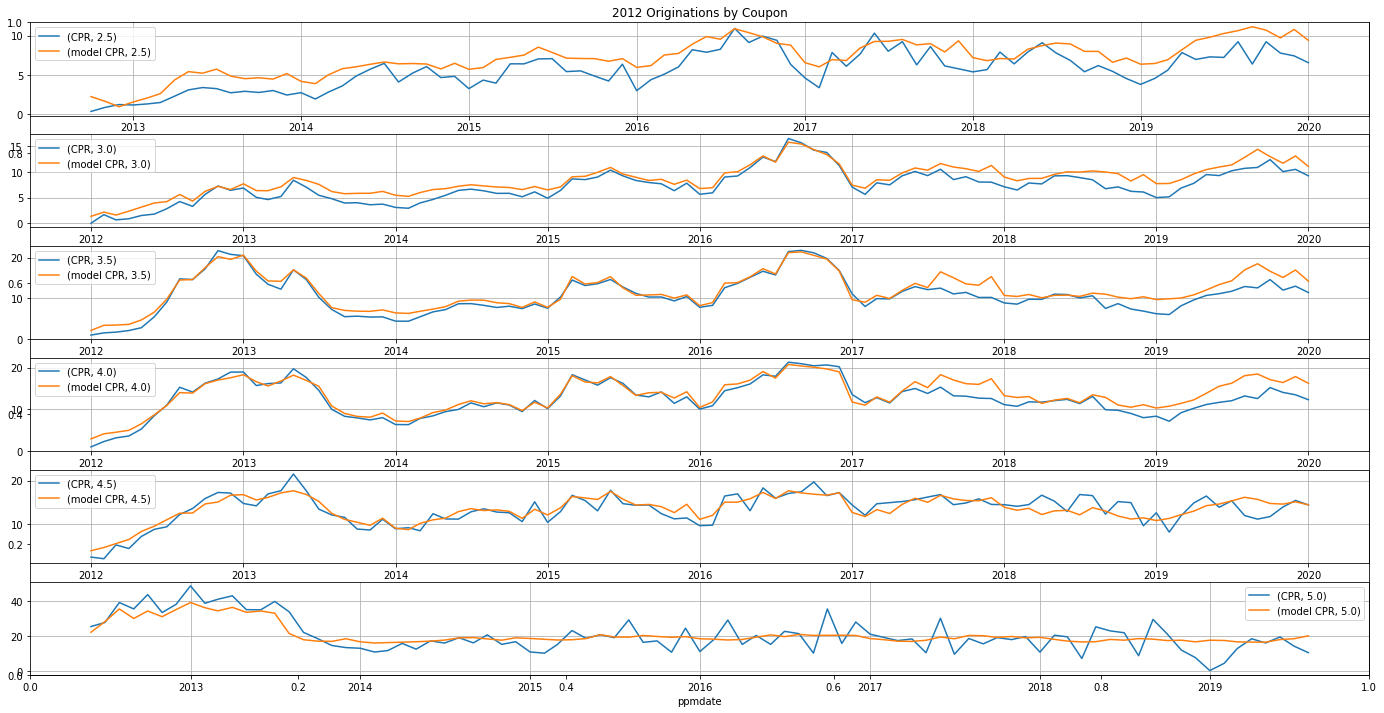

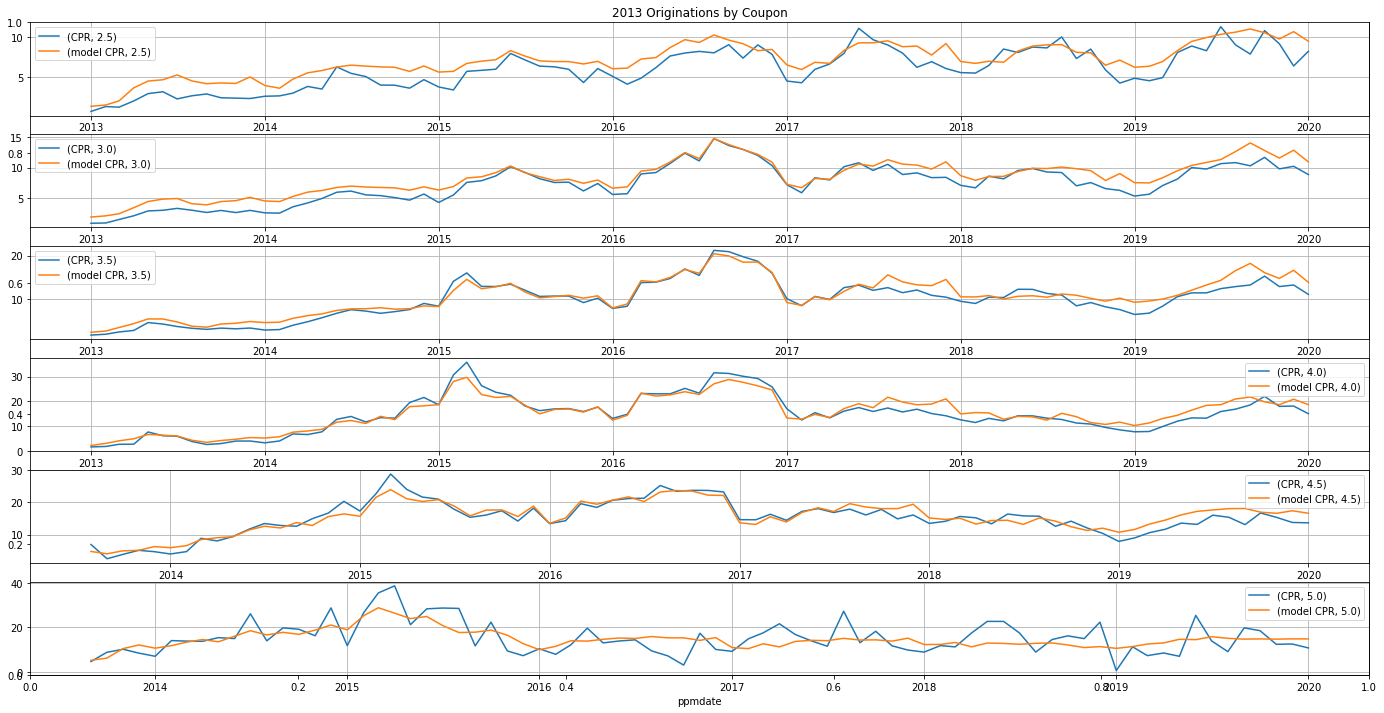

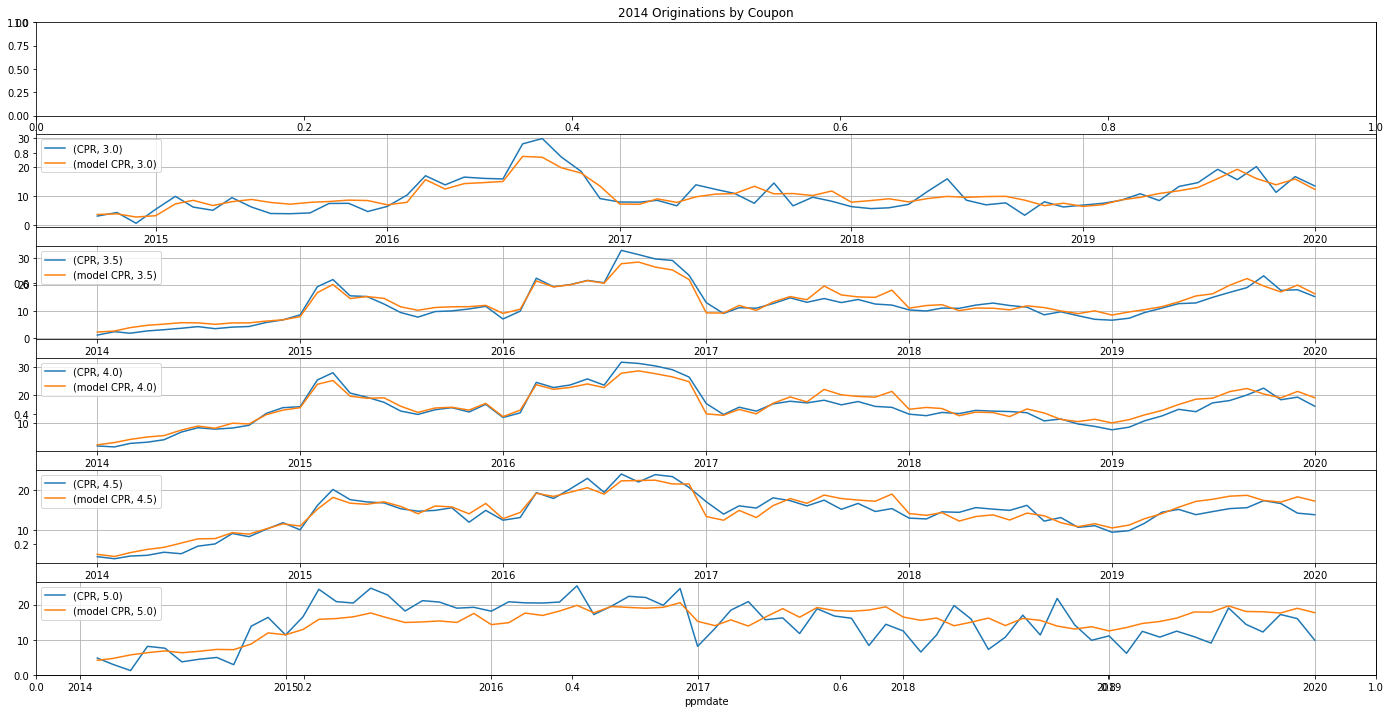

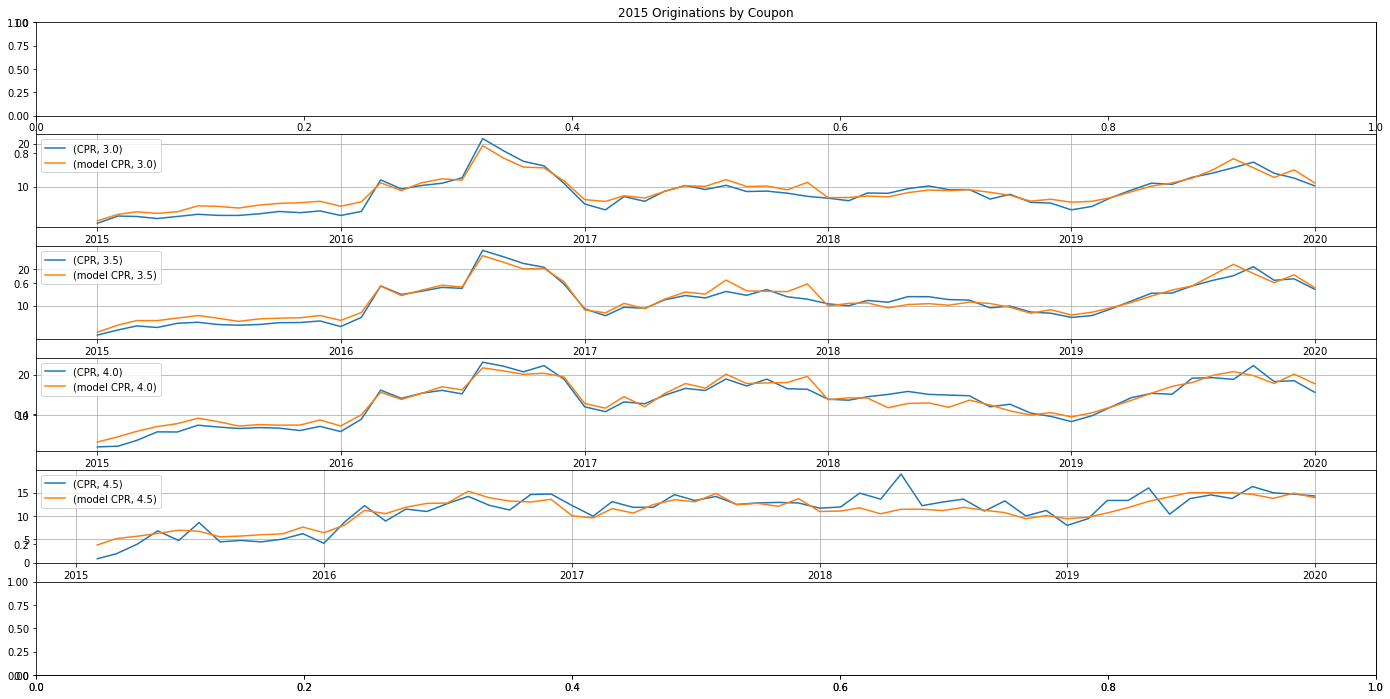

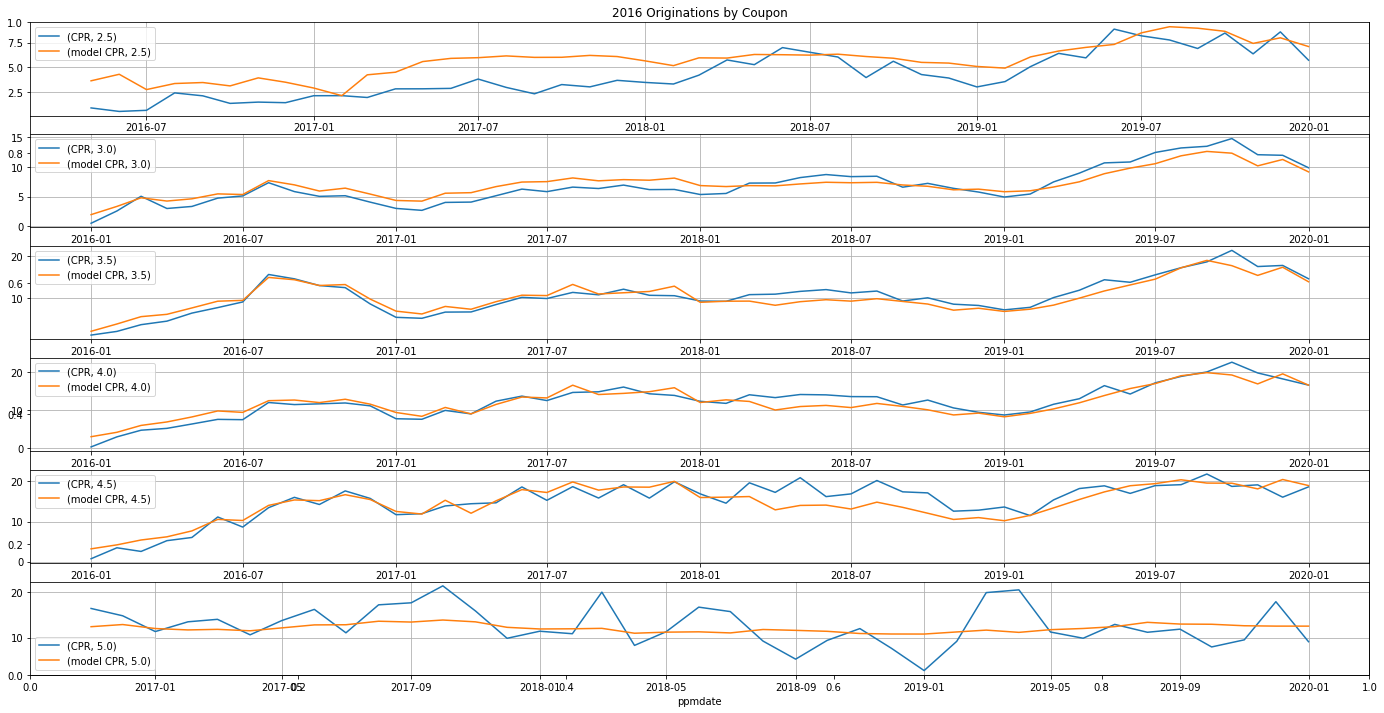

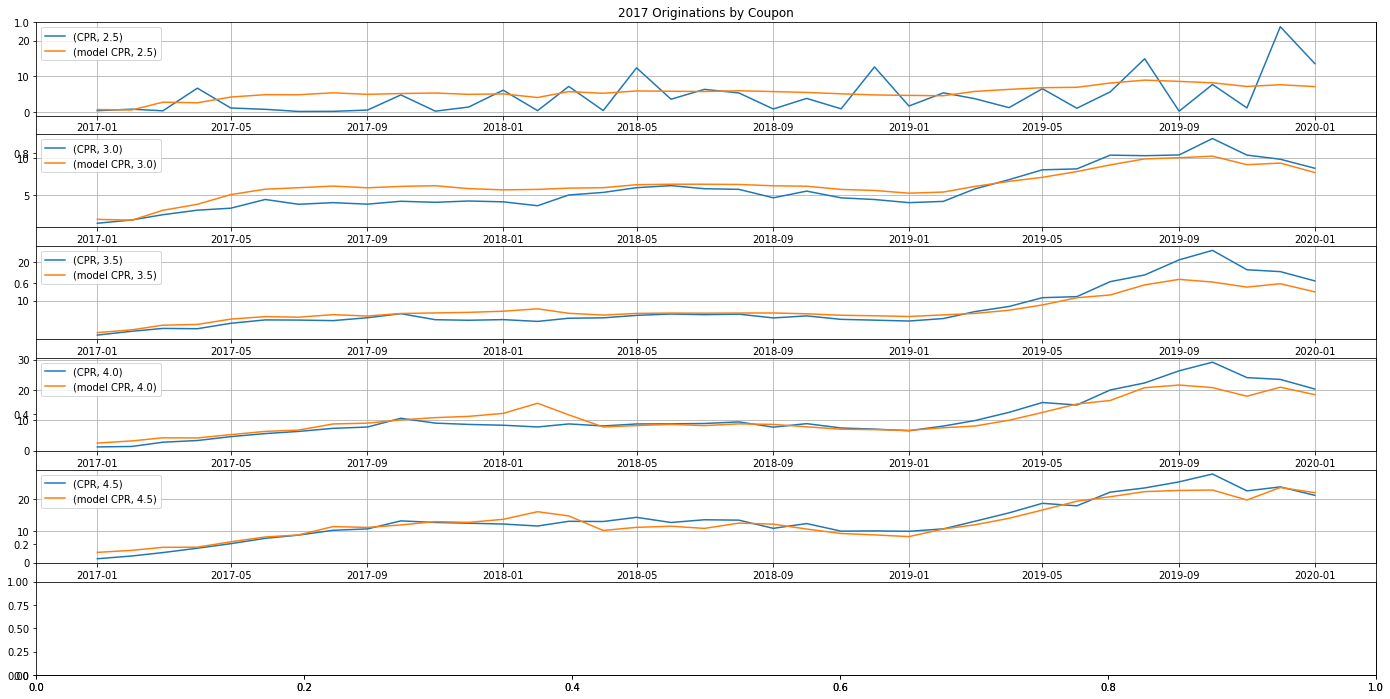

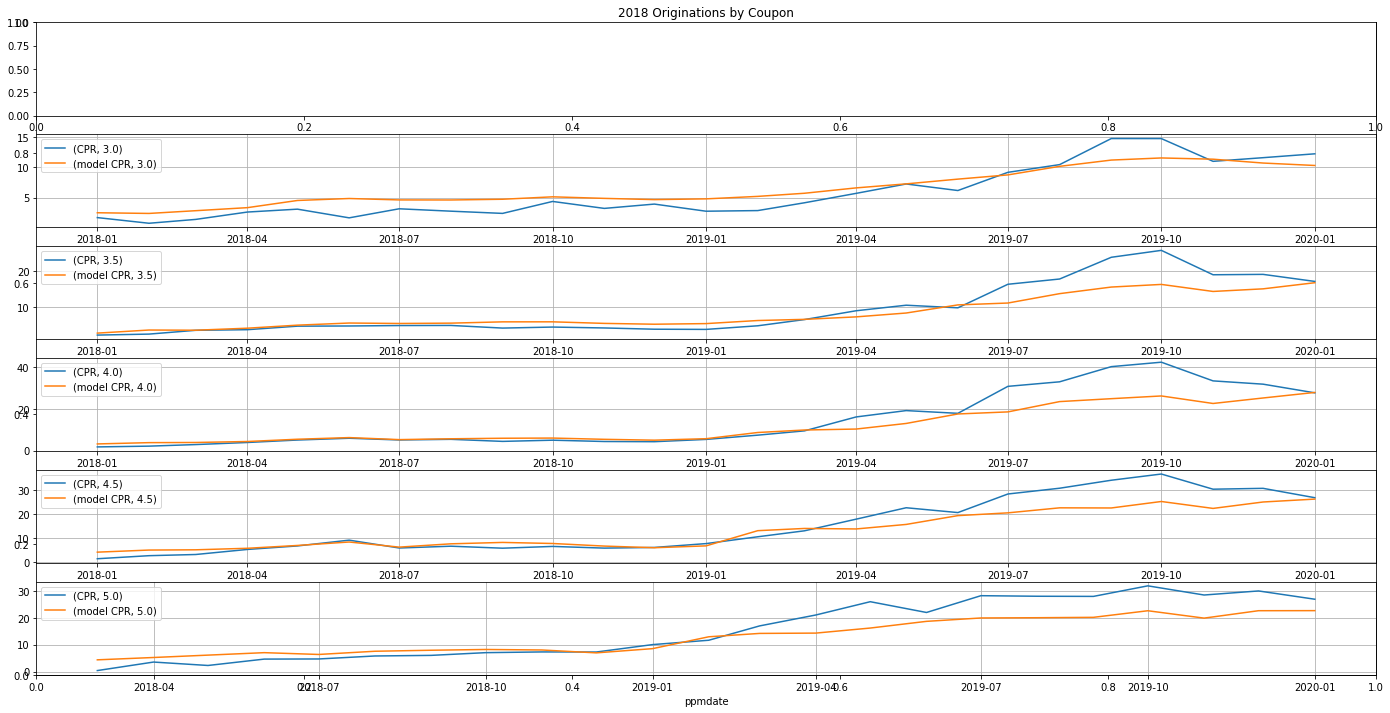

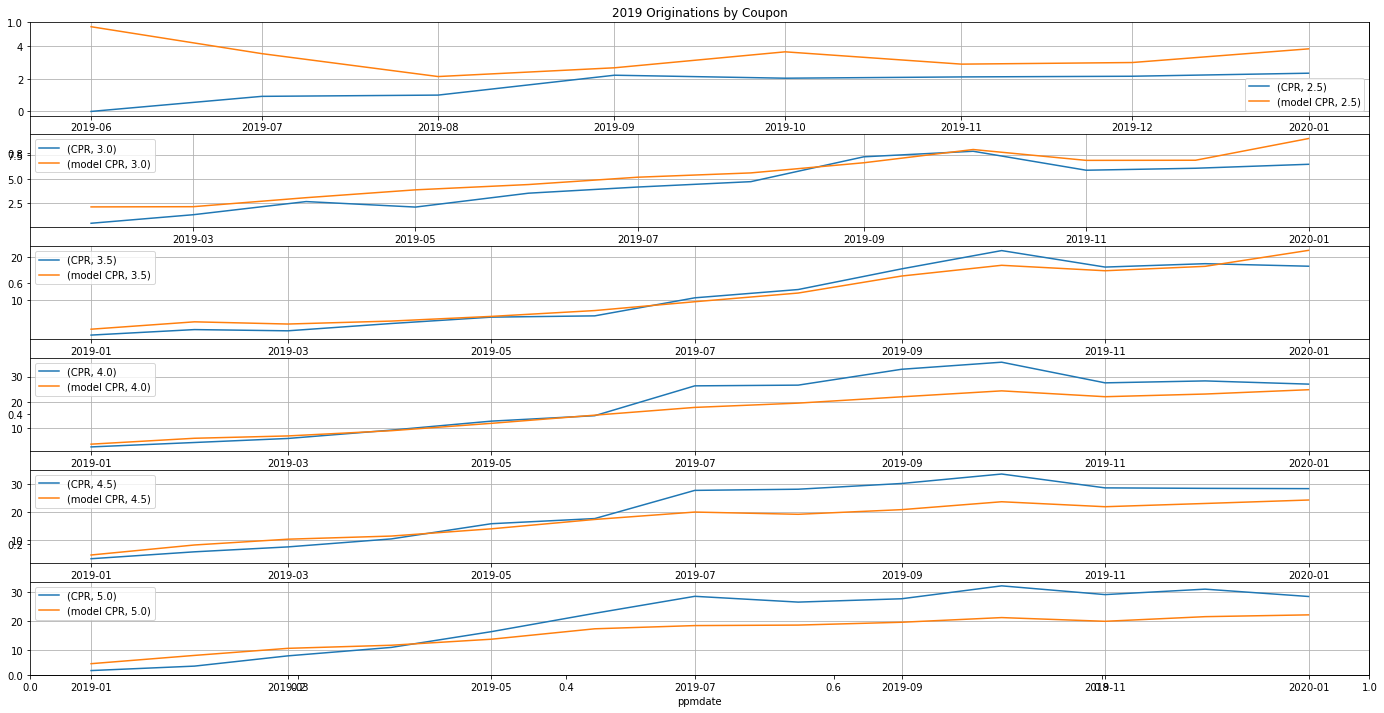

In [43]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:

    valReport(df[df['Vintage'] == vintage],graphTitle=f'{vintage} Originations by Coupon',fsize=(24,12))

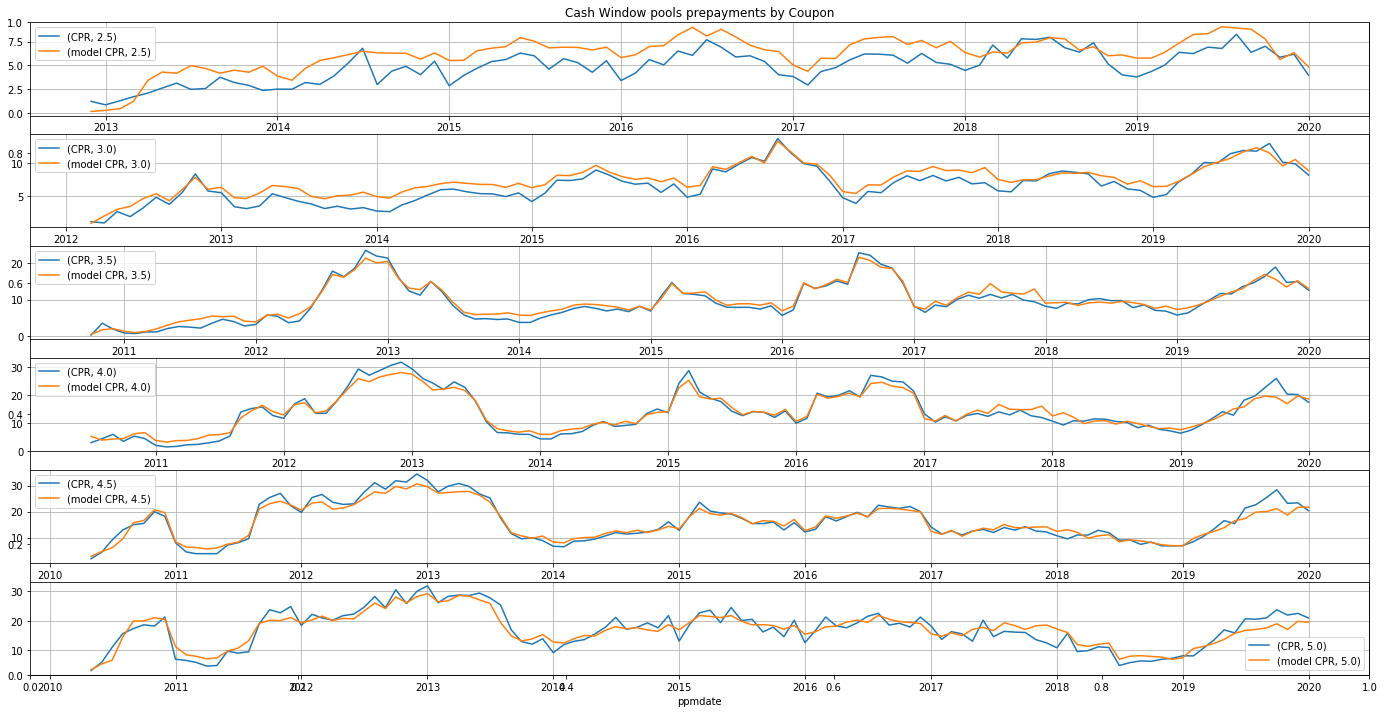

In [44]:
valReport(df[(df['%CashWindow'] == 100) & (df['Vintage'] > 2009)],graphTitle='Cash Window pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

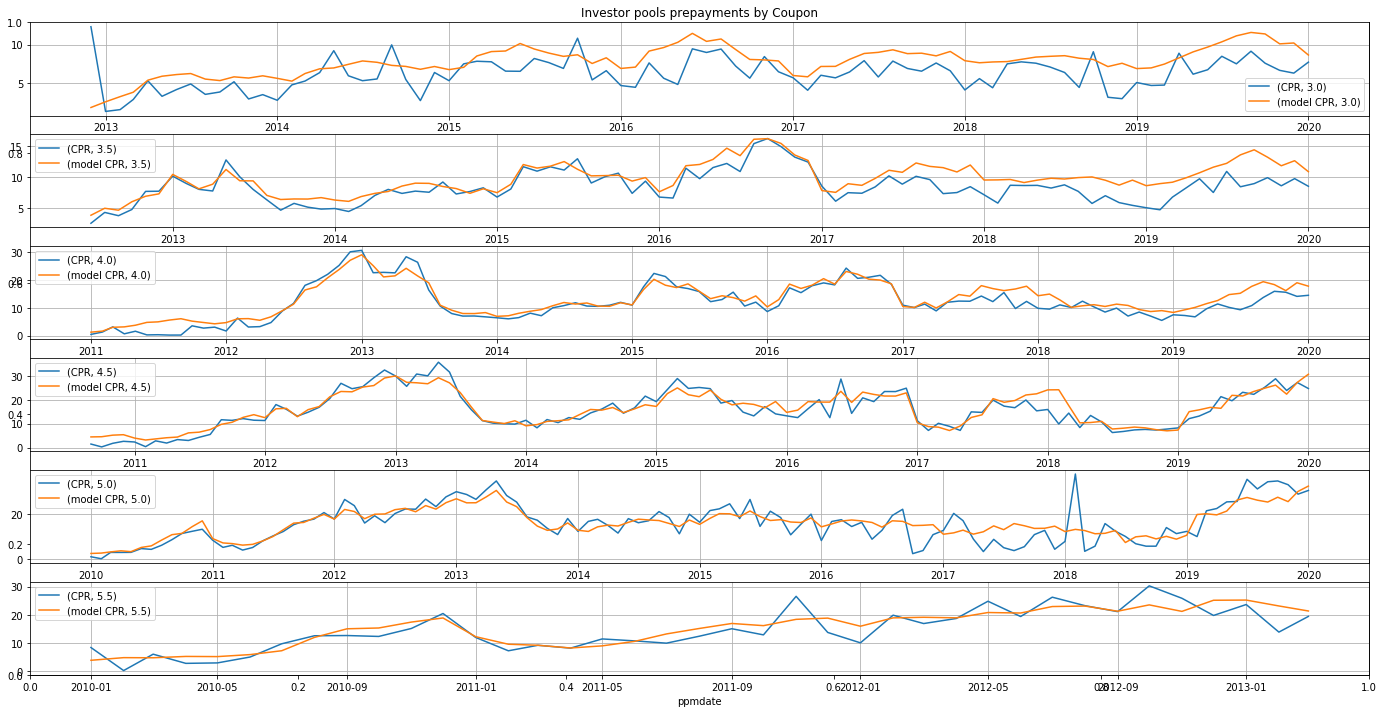

In [45]:
valReport(df[(df['OccPct_investor'] > 99) & (df['Vintage'] > 2009)],graphTitle='Investor pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

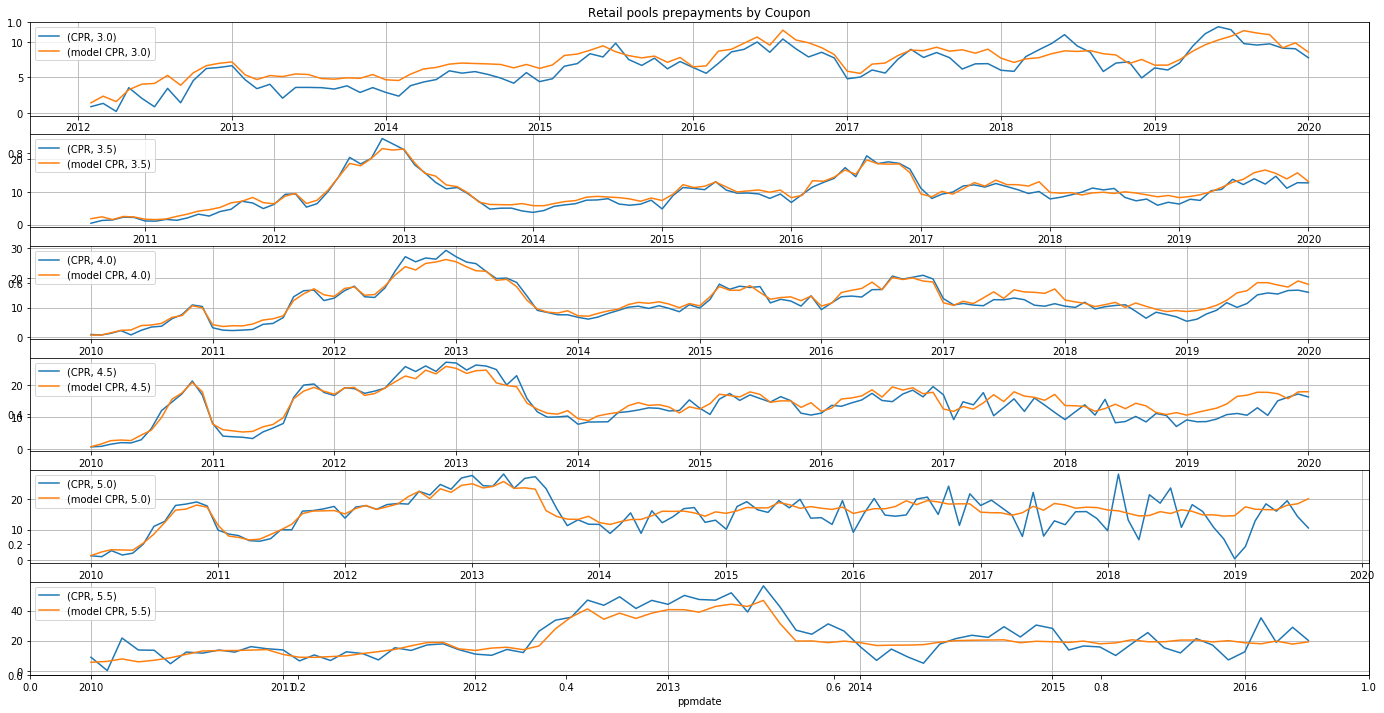

In [46]:
valReport(df[(df['PctChannel_Retail'] > 99) & (df['Vintage'] > 2009)],graphTitle='Retail pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

### Comparison of RMSEs for the three models

In [204]:
np.round(pd.concat([RMSEs_linear_model, RMSEs_random_forest, RMSEs_nn],axis=1),2)

LM RMSE (CPR)  RF RMSE (CPR)  NN RMSE (CPR)
Coupon                                             
2.5              1.37           1.37           1.37
3.0              1.02           1.02           1.02
3.5              1.37           1.37           1.37
4.0              3.16           3.16           3.16
4.5              3.14           3.14           3.14
5.0              3.63           3.63           3.63

### Conclusions about using a neural network model for predicting prepayment speeds

* In this project we have built a neural network-based mortgage prepayment model and have showed that such a model has a satisfactory predictive power and its output depends on model inputs in a way that makes economic sense. 
* The relative speed with which such models can be developed potentially gives a desirable advantage to any mortgage investor who wants to be able to adjust to regime changes in the mortgage market as quickly as possible and to any risk manager who wants to risk manage mortgage assets as accurately as possible. 
* Although, in our study we have chosen to have a 3 year out of sample period, in the industry such models are updated much more frequently. In particular, this modeling approach allows us to update a model on a monthly basis and just in one day. For some types of mortgage trades the short horizon prepayment predictions are the most important, and surely a 1-month old model is capable of making much better predictions than a 3-year old model. So, this approach has a lot of potential and many potential use cases.

### Save the neural network prepayment model in .h5 format

In [149]:
from tensorflow.keras.models import load_model

C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [48]:
model_name

'nn-ppm-from-csv.h5'

#### Uncomment the line below if you would like to save

In [49]:
# model.save(model_name)

#### Uncomment the line below if you would like to load the model saved in Git repository

In [151]:
# model = load_model('nn-ppm-from-csv.h5')

#### Please, ignore the section below. 

In [51]:
# import kerastuner as kt 

In [52]:
# def model_builder(hp):

#     model = Sequential()
    
#     #input layer / first hidden layer

#     first_layer_neurons      = hp.Int('layer_1_units', min_value=32, max_value = 1024, step = 32)
#     first_layer_dropout_rate = hp.Float('layer_1_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(first_layer_neurons, input_dim=X_train.shape[1], activation='relu'))
#     model.add(Dropout(first_layer_dropout_rate))

#     # 2nd layer
#     second_layer_neurons      = hp.Int('layer_2_units', min_value=128, max_value = 512, step = 32)
#     second_layer_dropout_rate = hp.Float('layer_2_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(second_layer_neurons, activation='relu'))
#     model.add(Dropout(second_layer_dropout_rate))

#     # 3rd layer
#     third_layer_neurons      = hp.Int('layer_3_units', min_value=64, max_value = 256, step = 32)
#     third_layer_dropout_rate = hp.Float('layer_3_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(third_layer_neurons, activation='relu'))
#     model.add(Dropout(third_layer_dropout_rate))

#     # 4th layer
#     forth_layer_neurons      = hp.Int('layer_4_units', min_value=32, max_value = 128, step = 32)
#     forth_layer_dropout_rate = hp.Float('layer_4_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(forth_layer_neurons, activation='relu'))
#     model.add(Dropout(forth_layer_dropout_rate))

#     #output layer
#     model.add(Dense(1, activation='relu')) # relu activation is perfect here, because SMM cannot be negative

#     model.compile(optimizer='adam', loss='mse')
#     #model.compile(optimizer='rmsprop', loss='mse')    

#     return model

In [53]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_loss',
#                      max_epochs=10,
#                      hyperband_iterations=2,
#                      directory=os.path.normpath('C:/'),
#                      project_name='nn_ppm_model-' + dt.datetime.now().strftime('%Y-%M-%d-%H-%M-%S'))

In [54]:
# tuner.search(x=X_train,
#              y=y_train,
#              validation_data=(X_test,y_test),
#              batch_size=1024,
#              epochs=10)

In [55]:
# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [56]:
# model = tuner.hypermodel.build(best_hps)

In [57]:
# model.summary()

In [58]:
# tuner.results_summary()